In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive



## Dependencies

In [2]:
import string
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.functional import F
from torch.nn.utils.rnn import pad_sequence
from matplotlib import pyplot as plt

## Hyper-parameters

In [3]:
batch_size = 256
n_epochs = 200
lr = 0.001
hidden_size = 128
embedding_dims = 16
n_layers = 1
keep_prob = 0.2


## Preprocessing

Let's start by reading the dinosaur names from the dinosaur.txt text file.

In [4]:
data_path = "/content/drive/MyDrive/Datasets/LSTM/Dinosaur Name Generator/dinosaur.txt"
with open(data_path, "r") as fp:
  names = fp.read().lower().splitlines()

In [5]:
names[:10]

['aachenosaurus',
 'aardonyx',
 'abdallahsaurus',
 'abelisaurus',
 'abrictosaurus',
 'abrosaurus',
 'abydosaurus',
 'acanthopholis',
 'achelousaurus',
 'acheroraptor']

Now let's create a list of list of characters.

In [6]:
EOS = "EOS"

In [7]:
split_names = []
for name in names:
  split_name = list(name) + [EOS]
  split_names.append(split_name)

In [8]:
split_names[:10]

[['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'a', 'r', 'd', 'o', 'n', 'y', 'x', 'EOS'],
 ['a', 'b', 'd', 'a', 'l', 'l', 'a', 'h', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'b', 'e', 'l', 'i', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'b', 'r', 'i', 'c', 't', 'o', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'b', 'r', 'o', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'b', 'y', 'd', 'o', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'c', 'a', 'n', 't', 'h', 'o', 'p', 'h', 'o', 'l', 'i', 's', 'EOS'],
 ['a', 'c', 'h', 'e', 'l', 'o', 'u', 's', 'a', 'u', 'r', 'u', 's', 'EOS'],
 ['a', 'c', 'h', 'e', 'r', 'o', 'r', 'a', 'p', 't', 'o', 'r', 'EOS']]

And now let's create a vocabulary indicies.

In [9]:
vocab = [EOS] + list(string.ascii_lowercase)
idx2char = dict(enumerate(vocab))
char2idx = {char: idx for idx, char in enumerate(vocab)}

In [10]:
idx2char

{0: 'EOS',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [11]:
char2idx

{'EOS': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [12]:
encoded_names = []
for name in split_names:
  encoded_name = torch.tensor([char2idx[char] for char in name])
  encoded_names.append(encoded_name)

In [13]:
encoded_names[:10]

[tensor([ 1,  1,  3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  1, 18,  4, 15, 14, 25, 24,  0]),
 tensor([ 1,  2,  4,  1, 12, 12,  1,  8, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  2,  5, 12,  9, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  2, 18,  9,  3, 20, 15, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  2, 18, 15, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  2, 25,  4, 15, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  3,  1, 14, 20,  8, 15, 16,  8, 15, 12,  9, 19,  0]),
 tensor([ 1,  3,  8,  5, 12, 15, 21, 19,  1, 21, 18, 21, 19,  0]),
 tensor([ 1,  3,  8,  5, 18, 15, 18,  1, 16, 20, 15, 18,  0])]

In [14]:
padded_names = pad_sequence(encoded_names, batch_first=True, padding_value=0)
padded_names[:10]

tensor([[ 1,  1,  3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  1, 18,  4, 15, 14, 25, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  2,  4,  1, 12, 12,  1,  8, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  2,  5, 12,  9, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  2, 18,  9,  3, 20, 15, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  2, 18, 15, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  2, 25,  4, 15, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  3,  1, 14, 20,  8, 15, 16,  8, 15, 12,  9, 19,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 1,  3,  8,  5, 12, 15, 21, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,

## Dataset and DataLoader

In [16]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, samples):
    self.samples = samples

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    sample = self.samples[idx]
    X = sample[:-1]
    y = sample[1:]
    return X, y

In [17]:
dataset = Dataset(samples=padded_names)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [20]:
next(iter(dataset))

(tensor([ 1,  1,  3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]),
 tensor([ 1,  3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]))

In [21]:
next(iter(dataloader))

[tensor([[25, 21,  1,  ...,  0,  0,  0],
         [14, 15, 20,  ...,  0,  0,  0],
         [25, 21, 14,  ...,  0,  0,  0],
         ...,
         [ 4, 15, 12,  ...,  0,  0,  0],
         [ 8, 21,  1,  ...,  0,  0,  0],
         [12, 21,  6,  ...,  0,  0,  0]]),
 tensor([[21,  1, 14,  ...,  0,  0,  0],
         [15, 20, 15,  ...,  0,  0,  0],
         [21, 14,  7,  ...,  0,  0,  0],
         ...,
         [15, 12,  9,  ...,  0,  0,  0],
         [21,  1, 24,  ...,  0,  0,  0],
         [21,  6,  5,  ...,  0,  0,  0]])]

## Model Definition

In [22]:
class Model(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_size, n_layers, keep_prob):
    super(Model, self).__init__()

    self.vocab_size = vocab_size
    self.embedding_dims = embedding_dims
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.keep_prob = keep_prob

    self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dims)
    self.lstm = nn.LSTM(input_size=self.embedding_dims, hidden_size=self.hidden_size, num_layers=self.n_layers, batch_first=True)
    self.dropout = nn.Dropout(p=self.keep_prob)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)

  def forward(self, X, state_previous):
    h_previous, c_previous = state_previous
    embedding = self.embedding(X)
    y_hat, state_current = self.lstm(embedding, (h_previous, c_previous))
    y_hat = self.dropout(y_hat)
    y_hat = self.fc(y_hat)

    return y_hat, state_current

## Training

In [23]:
model = Model(vocab_size=len(char2idx), embedding_dims=embedding_dims, hidden_size=hidden_size, n_layers=n_layers, keep_prob=keep_prob)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [29]:
for batch, (X, y) in enumerate(dataloader):
  print(X.size(0))

256
256
256
256
256
256
9


In [ ]:
for batch, (X, y) in enumerate(dataloader):
  print(y)
  print(y.size())

In [ ]:
y = torch.tensor([
    [
        [1,2,3],
        [4,5,6]
    ],
    [
        [7,8,9],
        [10,11,12]
    ],
    [
        [13,14,15],
        [16,17,18]
    ]
])
y

In [ ]:
y.size()

In [ ]:
y.transpose(1,2)

In [ ]:
model.train()

losses = []

for epoch in range(n_epochs):
  iteration_loss = 0
  for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()

    # forward propagation
    h_previous = torch.zeros(n_layers, X.size(0), hidden_size) 
    c_previous = torch.zeros(n_layers, X.size(0), hidden_size) 

    y_hat, state_current = model(X, (h_previous, c_previous))

    # loss calculation
    loss = criterion(y_hat.transpose(1, 2), y)
    iteration_loss += loss.item()

    # backward propagation
    loss.backward()
    optimizer.step()

    print(f"[{epoch + 1}/{n_epochs}, {batch + 1}/{len(dataloader)}]: loss = {loss.item()}")

  iteration_loss /= len(dataloader)
  losses.append(iteration_loss)

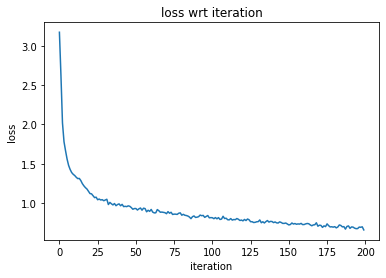

In [38]:
plt.plot(range(len(losses)), losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss wrt iteration")
plt.show()

## Saving the model

In [39]:
torch.save(model.state_dict(), "dino_name_generator.pt")

## Loading the model

In [40]:
model = Model(vocab_size=len(char2idx), embedding_dims=embedding_dims, hidden_size=hidden_size, n_layers=n_layers, keep_prob=keep_prob)
model.load_state_dict(torch.load("/content/drive/MyDrive/Datasets/LSTM/Dinosaur Name Generator/dino_name_generator.pt"))

<All keys matched successfully>


## Sampling

Sampling using a random initial character.

In [41]:
# model.eval()
characters = []
character_idx = torch.randint(low=1, high=len(vocab), size=(1,1))
characters.append(character_idx.squeeze().item())
h_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)
c_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)

with torch.no_grad():
  while character_idx.squeeze().item() != char2idx["EOS"]:
    y_hat, state_current = model(character_idx, (h_previous, c_previous))
    softmax_y_hat = F.softmax(y_hat, dim=-1)
    character_idx = torch.argmax(softmax_y_hat, dim=-1)
    characters.append(character_idx.squeeze().item())

    h_previous, c_previous = state_current 

name = "".join([idx2char[character] for character in characters if character != 0])
authenticity = "real dinosaur" if name in names else "made up"
print(f"THE MODEL HAVE GENERATED THE NAME \"{name}\", WHICH IS A **{authenticity}** NAME")
if name not in names:
  with open("/content/drive/MyDrive/Datasets/LSTM/Dinosaur Name Generator/gen_names.txt", "a+") as fp:
    fp.seek(0)
    fp_names = fp.read().splitlines()
    if name not in fp_names:
      fp.seek(0, 2)
      fp.write(f"{name}\n") 

THE MODEL HAVE GENERATED THE NAME "wangosaurus", WHICH IS A **made up** NAME


Sampling using a pre-determined initial character.

In [52]:
# model.eval()
characters = []
initial_character = input(">> input an initial dinosaur name character: ")
character_idx = torch.tensor([[char2idx[initial_character]]])
characters.append(character_idx.squeeze().item())
h_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)
c_previous = torch.zeros(n_layers, character_idx.size(0), hidden_size)

with torch.no_grad():
  while character_idx.squeeze().item() != char2idx["EOS"]:
    y_hat, state_current = model(character_idx, (h_previous, c_previous))
    softmax_y_hat = F.softmax(y_hat, dim=-1)
    character_idx = torch.argmax(softmax_y_hat, dim=-1)
    characters.append(character_idx.squeeze().item())

    h_previous, c_previous = state_current 

name = "".join([idx2char[character] for character in characters if character != 0])
authenticity = "real dinosaur" if name in names else "made up"
print(f"THE MODEL HAVE GENERATED THE NAME \"{name}\", WHICH IS A **{authenticity}** NAME")
if name not in names:
  with open("/content/drive/MyDrive/Datasets/LSTM/Dinosaur Name Generator/gen_names.txt", "a+") as fp:
    fp.seek(0)
    fp_names = fp.read().splitlines()
    if name not in fp_names:
      fp.seek(0, 2)
      fp.write(f"{name}\n") 

>> input an initial dinosaur name character: l
THE MODEL HAVE GENERATED THE NAME "lantanosaurus", WHICH IS A **made up** NAME
